Get statistics about the dataset

In [1]:
import sparqlqueries as sq
import pandas as pd
import matplotlib.pyplot as plt
import paths as p
import json
from tqdm import tqdm

In [2]:
melart_annotations=json.load(open(p.MELART_ANNOTATIONS_PATH, 'r'))

In [3]:
artworks_qids=dict() # split -> list of qids (keys from the melart annotations)
for qid,melart_artwork in melart_annotations.items():
    split=melart_artwork['split']
    if split not in artworks_qids:
        artworks_qids[split]=[]
    artworks_qids[split].append(qid)
print([f"Split {split}: {len(qids)} artworks" for split,qids in artworks_qids.items()])

['Split test: 100 artworks', 'Split train: 1188 artworks', 'Split val: 328 artworks']


In [4]:
all_qids=[qid for split,qids in artworks_qids.items() for qid in qids]
print(f"Total: {len(all_qids)} artworks")

Total: 1616 artworks


In [5]:
mentions_qids=set()
mention_counts=dict()
for split,qids in artworks_qids.items():
    for qid in qids:
        for match_list in melart_annotations[qid]['visual_el_matches']+melart_annotations[qid]['contextual_el_matches']:
            for match in match_list:
                mentions_qids.add(match['qid'])
                if match['qid'] not in mention_counts:
                    mention_counts[match['qid']]=0
                mention_counts[match['qid']]+=1
total_mentions=sum(mention_counts.values())
print(f"Total: {len(mentions_qids)} entities in the mentions")
print(f"Total: {total_mentions} mentions")

Total: 1306 entities in the mentions
Total: 6585 mentions


Read jsonl of candidates

In [6]:
candidates=dict()
with open(p.CANDIDATES_FILE_PATH, 'r') as f:
    for line in f:
        candidate=json.loads(line)
        qid=candidate['qid']
        candidates[qid]=candidate
print(f"Read {len(candidates)} candidates")

Read 52769 candidates


In [7]:
def get_all_types(qid_list):
    """Get all types in the wikidata hierarchy for a list of qids, return a dataframe with columns 'qid', 'type' and 'type_label'"""
    types_dict=dict()
    # sparql_query="""
    # PREFIX wd: <http://www.wikidata.org/entity/>
    # PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    # PREFIX p: <http://www.wikidata.org/prop/>
    # prefix ps: <http://www.wikidata.org/prop/statement/>
    # PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

    # SELECT DISTINCT ?qid ?type ?type_label WHERE{
    #     VALUES ?qid { %s }
    #     ?qid p:P31 ?statement0.
    #     ?statement0 (ps:P31/(wdt:P279*)) ?type.
    #     ?type rdfs:label ?type_label.
    #     FILTER ( STRSTARTS(STR(?type), STR(wd:)))
    #     FILTER ( LANG(?type_label) = "en" )
    # }
    # """ % ' '.join([f'wd:{qid}' for qid in qid_list])
    sparql_query="""
    PREFIX wd: <http://www.wikidata.org/entity/>
    PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    PREFIX p: <http://www.wikidata.org/prop/>
    prefix ps: <http://www.wikidata.org/prop/statement/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

    SELECT DISTINCT ?qid ?type WHERE{
        VALUES ?qid { %s }
        ?qid p:P31 ?statement0.
        ?statement0 (ps:P31/(wdt:P279*)) ?type.
        FILTER ( STRSTARTS(STR(?type), STR(wd:)))
    }
    """ % ' '.join([f'wd:{qid}' for qid in qid_list])
    results=sq.sparql_pandas_query(sparql_query)
    results['qid']=results['qid'].apply(lambda x: x.split('/')[-1])
    results['type']=results['type'].apply(lambda x: x.split('/')[-1])
    return results
get_all_types(['Q159099','Q259261'])

,qid,type
0,Q159099,Q103940464
1,Q159099,Q106559804
2,Q159099,Q110224119
3,Q159099,Q110551885
4,Q159099,Q12898224
5,Q159099,Q154954
6,Q159099,Q159344
7,Q159099,Q164509
8,Q159099,Q215627
9,Q159099,Q24229398


def build_type_hierarchy(seed_types):
    """Build a dictionary with the type hierarchy in wikidata"""
    print(f"Building hierarchy from seed types")
    sparql_query="""
    PREFIX wd: <http://www.wikidata.org/entity/>
    PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    PREFIX p: <http://www.wikidata.org/prop/>
    prefix ps: <http://www.wikidata.org/prop/statement/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

    SELECT DISTINCT ?aux_type ?parent_type WHERE{
        VALUES ?type { %s }
        ?type wdt:P279* ?aux_type.
        ?aux_type wdt:P279 ?parent_type.
    }
    """ % ' '.join([f'wd:{type}' for type in seed_types])
    results=sq.sparql_pandas_query(sparql_query)
    tqdm_results=tqdm(total=results.shape[0], desc="Building hierarchy")
    hierarchy=dict()
    while not results.empty:
        res_copy=results.copy(deep=True)
        res_copy["leaf"]=~res_copy['aux_type'].isin(res_copy['parent_type']) # there might be cycles in the hierarchy, we need to detect them
        
        leaves_df=res_copy[res_copy['leaf']]
        for i,row in leaves_df.iterrows():
            parent_type=row['parent_type']
            aux_type=row['aux_type']
            if parent_type not in hierarchy:
                hierarchy[parent_type]=[]
            if aux_type not in hierarchy:
                hierarchy[parent_type].append(aux_type)
            else:
                aux_type_obj=hierarchy.pop(aux_type)
                hierarchy[parent_type].append(aux_type_obj)
        results=res_copy[~res_copy['leaf']].copy(deep=True)
        tqdm_results.update(leaves_df.shape[0])
    return hierarchy

hierarchy_dict=build_type_hierarchy(['Q5','Q20643955'])
print(json.dumps(hierarchy_dict, indent=4))

full_type_hierarchy=build_type_hierarchy(dataset_types)

In [ ]:
# dataframe with qid and type
dfs=[]
batch_size=1000
all_candidate_qids=list(candidates.keys())
batched_candidates=[{qid:candidates[qid] for qid in all_candidate_qids[i:i+batch_size]} for i in range(0, len(all_candidate_qids), batch_size)]
dataset_types=[candidates[qid]["types"].keys() for qid in all_candidate_qids]
dataset_types=list(set([item for sublist in dataset_types for item in sublist]))
for batch in tqdm(batched_candidates):
    types_entity_df=get_all_types(batch.keys())
    types_entity_df=types_entity_df[types_entity_df['type'].isin(dataset_types)]
    dfs.append(types_entity_df)
df_types=pd.concat(dfs)
print("Total candidates type triples:", len(df_types))

100%|██████████| 53/53 [00:22<00:00,  2.31it/s]

Total candidates type triples: 453575


,qid,type
3,Q100322415,Q12042203
5,Q100322415,Q134307
6,Q100322415,Q15621286
8,Q100322415,Q17537576
10,Q100322415,Q241045


In [9]:
df_types[df_types['qid']=='Q345']

,qid,type
15755,Q345,Q110224119
15758,Q345,Q12405827
15760,Q345,Q13002315
15764,Q345,Q18563354
15766,Q345,Q20643955
15767,Q345,Q21070568
15771,Q345,Q24334685
15772,Q345,Q26401003
15775,Q345,Q3778211
15776,Q345,Q4271324


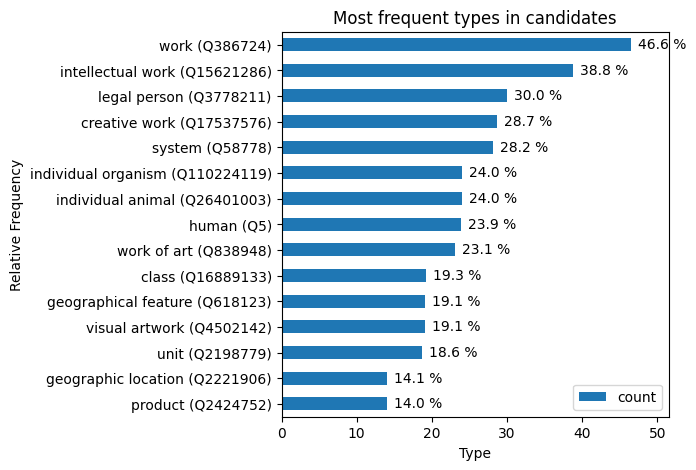

In [10]:
# count of types
type_counts=df_types['type'].value_counts()
#normalize
type_counts=type_counts*100/len(candidates)
k=15
plot_df=pd.DataFrame(type_counts.head(k))
plot_labels=sq.sparql_all_lables(plot_df.index.to_list())
plot_df["type_label"]=plot_df.index.map(lambda x: f"{plot_labels[x][0]} ({x})")
plot_df=plot_df.set_index("type_label")
ax=plot_df.plot(kind='barh', title='Most frequent types in candidates', figsize=(5,5), xlabel='Type', ylabel='Relative Frequency', xlim=(0,max(type_counts.head(10))+5))
ax.invert_yaxis()
ax.bar_label(ax.containers[0], fmt='%.1f %%', padding=5)
plt.savefig("figures/types_candidates.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [11]:
df_types_mentions=df_types[df_types['qid'].isin(mentions_qids)]
print("Total mention types triples:", len(df_types_mentions))

Total mention types triples: 10064


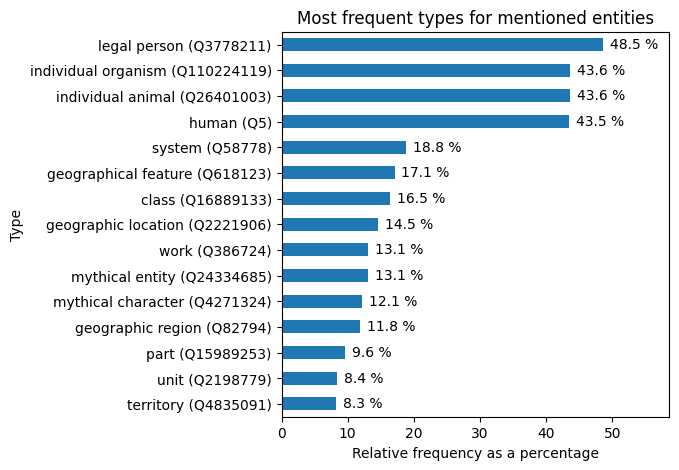

In [12]:
type_counts_mentions=df_types_mentions['type'].value_counts()
#normalize
type_counts_mentions=type_counts_mentions*100/len(mentions_qids)
k=15
plot_df=pd.DataFrame(type_counts_mentions.head(k))
plot_labels=sq.sparql_all_lables(plot_df.index.to_list())
plot_df["type_label"]=plot_df.index.map(lambda x: f"{plot_labels[x][0]} ({x})")
plot_df=plot_df.set_index("type_label")
ax=plot_df.plot(kind='barh', title='Most frequent types for mentioned entities', figsize=(5,5), ylabel='Type', xlabel='Relative frequency as a percentage', xlim=(0,max(type_counts_mentions.head(10))+10), legend=False)
ax.invert_yaxis()
ax.bar_label(ax.containers[0], fmt='%.1f %%', padding=5)
plt.savefig("figures/types_mentions.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [13]:
# legal persons (Q3778211) that are not humans (Q5)
legal_persons_df=df_types_mentions[df_types_mentions['type']=='Q3778211']
humans_df=df_types_mentions[df_types_mentions['type']=='Q5']
weird_legal_persons_df=legal_persons_df[~legal_persons_df['qid'].isin(humans_df['qid'])]
# distinct qids
weird_legal_persons_qids=set(weird_legal_persons_df['qid'])
weird_legal_persons_qids

{'Q10053',
 'Q12994',
 'Q1361268',
 'Q1492',
 'Q15077294',
 'Q151030',
 'Q159',
 'Q159605',
 'Q1602820',
 'Q160483',
 'Q16327702',
 'Q1640215',
 'Q164061',
 'Q181946',
 'Q191415',
 'Q1975176',
 'Q19862731',
 'Q20427',
 'Q2044',
 'Q212406',
 'Q2186',
 'Q220',
 'Q221507',
 'Q249679',
 'Q254829',
 'Q2634',
 'Q26421',
 'Q272101',
 'Q27613',
 'Q29',
 'Q290936',
 'Q30974',
 'Q329967',
 'Q34404',
 'Q3709831',
 'Q41',
 'Q42288',
 'Q426375',
 'Q43999',
 'Q4640',
 'Q4649',
 'Q48292',
 'Q486792',
 'Q49186',
 'Q499537',
 'Q539123',
 'Q5447471',
 'Q5776',
 'Q5836',
 'Q60',
 'Q604222',
 'Q6247',
 'Q6343',
 'Q64',
 'Q641',
 'Q690',
 'Q70899',
 'Q772',
 'Q772054',
 'Q80591',
 'Q819267',
 'Q822',
 'Q830183',
 'Q90',
 'Q928',
 'Q9920'}

[Text(5, 0, '48.5 %'),
 Text(5, 0, '43.6 %'),
 Text(5, 0, '43.6 %'),
 Text(5, 0, '43.5 %'),
 Text(5, 0, '18.8 %'),
 Text(5, 0, '17.1 %'),
 Text(5, 0, '16.5 %'),
 Text(5, 0, '14.5 %'),
 Text(5, 0, '13.1 %'),
 Text(5, 0, '13.1 %'),
 Text(5, 0, '12.1 %'),
 Text(5, 0, '11.8 %'),
 Text(5, 0, '9.6 %'),
 Text(5, 0, '8.4 %'),
 Text(5, 0, '8.3 %')]

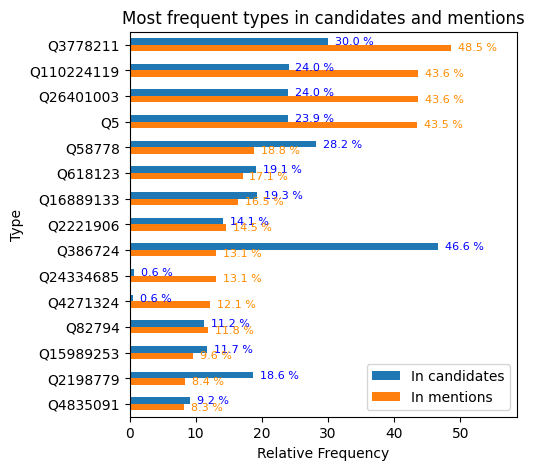

In [14]:
# combine the two type_count series into a dataframe
df_type_counts=pd.concat([type_counts, type_counts_mentions], axis=1)
df_type_counts.fillna(0, inplace=True)
df_type_counts.columns=['In candidates','In mentions']
df_type_counts.sort_values(by='In mentions', ascending=False, inplace=True)
ax=df_type_counts.head(15).plot(kind='barh', title='Most frequent types in candidates and mentions', figsize=(5,5), ylabel='Type', xlabel='Relative Frequency', xlim=(0,max(df_type_counts.head(15).max())+10), legend=True)
ax.invert_yaxis()
ax.bar_label(ax.containers[0], fmt='%.1f %%', padding=5, color='blue', fontsize=8)
ax.bar_label(ax.containers[1], fmt='%.1f %%', padding=5, color='darkorange', fontsize=8)

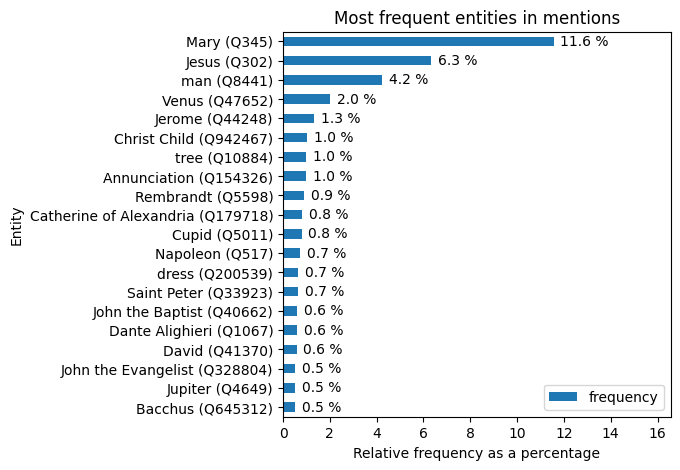

In [33]:
df_mention_counts=pd.DataFrame(mention_counts.items(), columns=['qid','count'])
mentions_labels=sq.sparql_all_lables(list(mentions_qids))
df_mention_counts['label']=df_mention_counts['qid'].map(lambda x: f"{mentions_labels[x][0]} ({x})")
df_mention_counts["frequency"]=df_mention_counts['count']*100/total_mentions
df_mention_counts.sort_values(by='count', ascending=False, inplace=True)
k=20
ax=df_mention_counts.head(k).plot(kind='barh', x='label', y='frequency', title='Most frequent entities in mentions', figsize=(5,5), xlabel='Relative frequency as a percentage', ylabel='Entity', xlim=(0,max(df_mention_counts.head(k)['frequency'])+5))
ax.invert_yaxis()
ax.bar_label(ax.containers[0], fmt='%.1f %%', padding=5)
plt.savefig("figures/top_entities_mentions.pdf", format="pdf", bbox_inches='tight')

In [16]:
df_mention_counts["cum_frequency"]=df_mention_counts['frequency'].cumsum()
df_mention_counts["rank"]=range(1,len(df_mention_counts)+1)
df_mention_counts["rank_relative"]=df_mention_counts["rank"]*100/len(df_mention_counts)
df_mention_counts.head(10)

,qid,count,label,frequency,cum_frequency,rank,rank_relative
0,Q345,761,Mary (Q345),11.556568,11.556568,1,0.076570
2,Q302,416,Jesus (Q302),6.317388,17.873956,2,0.153139
140,Q8441,279,man (Q8441),4.236902,22.110858,3,0.229709
31,Q47652,132,Venus (Q47652),2.004556,24.115414,4,0.306279
22,Q44248,86,Jerome (Q44248),1.305998,25.421412,5,0.382848
1,Q942467,68,Christ Child (Q942467),1.032650,26.454062,6,0.459418
188,Q10884,66,tree (Q10884),1.002278,27.456340,7,0.535988
15,Q154326,65,Annunciation (Q154326),0.987092,28.443432,8,0.612557
409,Q5598,58,Rembrandt (Q5598),0.880790,29.324222,9,0.689127
46,Q179718,54,Catherine of Alexandria (Q179718),0.820046,30.144267,10,0.765697


5% of entities account for 50% of mentions
33% of entities account for 80% of mentions
55% of entities account for 90% of mentions


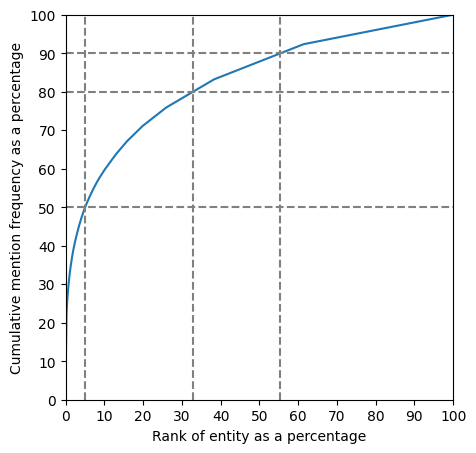

In [32]:
ax=df_mention_counts.plot(x='rank_relative', y='cum_frequency', figsize=(5,5), xlabel='Rank of entity as a percentage', ylabel='Cumulative mention frequency as a percentage', xticks=range(0,101,10), yticks=range(0,101,10), xlim=(0,100), ylim=(0,100), legend=False)
crossings=[50,80,90]
for crossing in crossings:
    y=crossing
    x=df_mention_counts[df_mention_counts["cum_frequency"]>=y].iloc[0]["rank_relative"]
    ax.axhline(y, color='grey', linestyle='--')
    ax.axvline(x, color='grey', linestyle='--')
    print(f"{round(x)}% of entities account for {y}% of mentions")
    #ax.text(x+1, y+1, text, color='red')
plt.savefig("figures/cumulative_mentions.pdf", format="pdf", bbox_inches='tight')


Adjust the types according to the mentions count. For instance Mary is mentioned multiple types, so her types are "mentioned" multiple times.

In [18]:
#combine df_mention_counts and df_types
df_mention_types=df_mention_counts.merge(df_types, on='qid')
df_mention_types.head()

,qid,count,label,frequency,cum_frequency,rank,rank_relative,type
0,Q345,761,Mary (Q345),11.556568,11.556568,1,0.07657,Q110224119
1,Q345,761,Mary (Q345),11.556568,11.556568,1,0.07657,Q12405827
2,Q345,761,Mary (Q345),11.556568,11.556568,1,0.07657,Q13002315
3,Q345,761,Mary (Q345),11.556568,11.556568,1,0.07657,Q18563354
4,Q345,761,Mary (Q345),11.556568,11.556568,1,0.07657,Q20643955


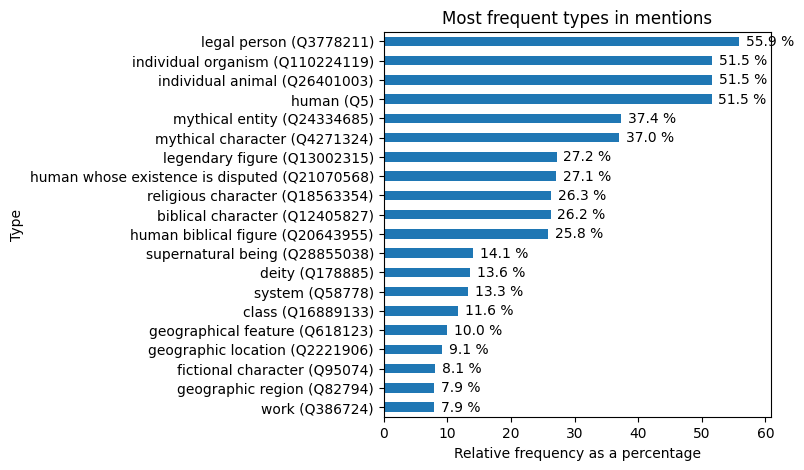

In [24]:
# group by type and sum the counts
df_mention_types_grouped=df_mention_types.groupby('type').sum(numeric_only=True).sort_values(by='count', ascending=False)
# keep only the count column
df_mention_types_grouped=df_mention_types_grouped[['count']]
# normalize
df_mention_types_grouped['count_norm']=df_mention_types_grouped['count']*100/total_mentions
k=20
ax=df_mention_types_grouped.head(k).plot.barh(y='count_norm', title='Most frequent types in mentions', figsize=(5,5), xlabel='Relative frequency as a percentage', ylabel='Type', xlim=(0,max(df_mention_types_grouped['count_norm'].head(k))+5), legend=False)
ax.invert_yaxis()
ax.bar_label(ax.containers[0], fmt='%.1f %%', padding=5)
# add labels
type_labels=sq.sparql_all_lables(df_mention_types_grouped.head(k).index.to_list())
ax.set_yticklabels([f"{type_labels[type][0]} ({type})" for type in df_mention_types_grouped.head(k).index])

plt.savefig("figures/top_types_mentions.pdf", format="pdf", bbox_inches='tight')

In [26]:
sum(df_mention_types_grouped['count'])

55829